In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from scipy.ndimage import median_filter
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
#---- Dataset example: (main folder) filtered-train -> (subfolder/class) mm[class1], (subfolder/class) nm[class2] ----
#---- '/content/drive/MyDrive/dataset2/filtered-train/mm/ISIC_0000002.jpg',  ----
import pathlib

# Define the paths to the training and testing datasets
train_data_dir = '/content/drive/MyDrive/dataset2/filtered-train'
test_data_dir = '/content/drive/MyDrive/dataset2/filtered-test'

data_dir = pathlib.Path(train_data_dir)
test_dir = pathlib.Path(test_data_dir)


In [ ]:
print(data_dir)
print(list(data_dir.glob('mm/*')))

/content/drive/MyDrive/dataset2/filtered-train
[PosixPath('/content/drive/MyDrive/dataset2/filtered-train/mm/ISIC_0000002.jpg'), PosixPath('/content/drive/MyDrive/dataset2/filtered-train/mm/ISIC_0000026.jpg'), PosixPath('/content/drive/MyDrive/dataset2/filtered-train/mm/ISIC_0000004.jpg'), PosixPath('/content/drive/MyDrive/dataset2/filtered-train/mm/ISIC_0000031.jpg'), PosixPath('/content/drive/MyDrive/dataset2/filtered-train/mm/ISIC_0000029.jpg'), PosixPath('/content/drive/MyDrive/dataset2/filtered-train/mm/ISIC_0000030.jpg'), PosixPath('/content/drive/MyDrive/dataset2/filtered-train/mm/ISIC_0000074.jpg'), PosixPath('/content/drive/MyDrive/dataset2/filtered-train/mm/ISIC_0000078.jpg'), PosixPath('/content/drive/MyDrive/dataset2/filtered-train/mm/ISIC_0000054.jpg'), PosixPath('/content/drive/MyDrive/dataset2/filtered-train/mm/ISIC_0000035.jpg'), PosixPath('/content/drive/MyDrive/dataset2/filtered-train/mm/ISIC_0000049.jpg'), PosixPath('/content/drive/MyDrive/dataset2/filtered-train/mm/

/content/drive/MyDrive/dataset2/filtered-train/mm/ISIC_0000002.jpg


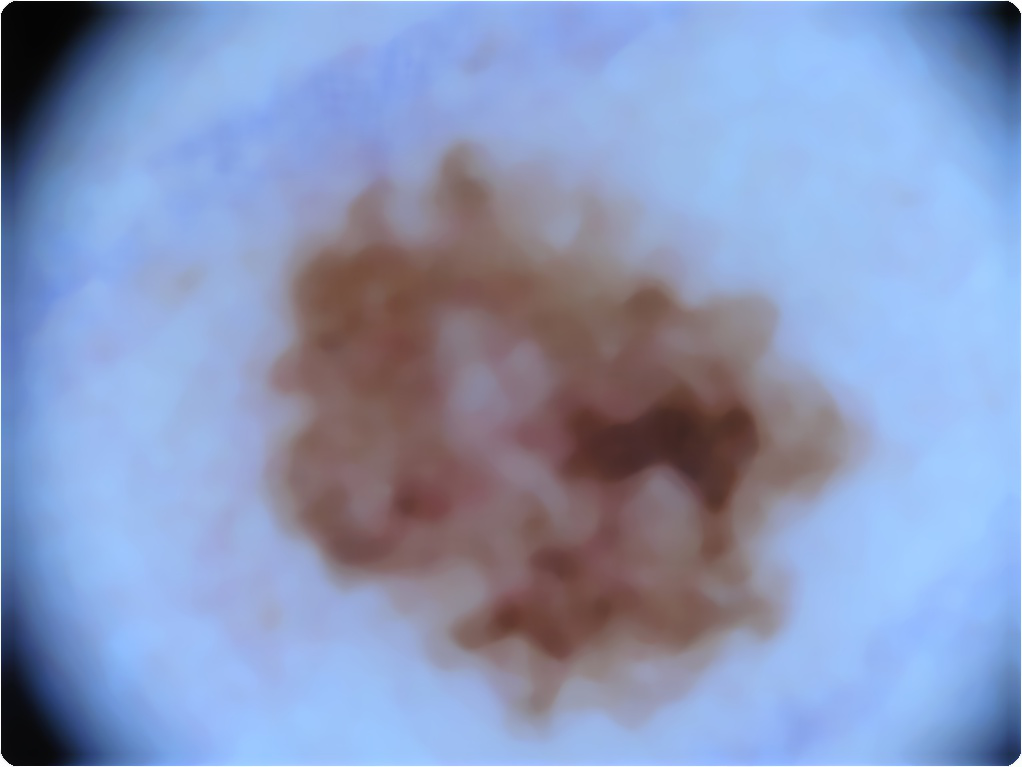

In [ ]:
melanoma = list(data_dir.glob('mm/*'))
print(melanoma[0])
PIL.Image.open(melanoma[0])

In [ ]:
img_height,img_width=224,224
batch_size=32
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  label_mode="binary",
  seed=123,
  image_size=(img_height, img_width),
  shuffle=True,
  batch_size=batch_size)

Found 900 files belonging to 2 classes.
Using 720 files for training.


In [ ]:

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  label_mode="binary",
  seed=123,
  image_size=(img_height, img_width),
  shuffle=False,
  batch_size=batch_size)     

Found 900 files belonging to 2 classes.
Using 180 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['mm', 'nm']


In [ ]:
#---- binary representation of mm and nm ----
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 10))
# for images, labels in train_ds.take(1):
#     for i in range(2):
#         ax = plt.subplot(1, 2, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8"))
#         plt.title(class_names[int(labels[i])])  # Convert the label to integer and access class_names
#         plt.axis("off")
#         print(labels[i].numpy())

In [ ]:
# pip install focal_loss

In [ ]:
def focal_loss(y_true, y_pred):
    gamma = 1.0  # The focusing parameter, you can adjust this value
    alpha = 0.1  # The balancing parameter, you can adjust this value

    # Convert the predicted labels to float32
    y_pred = tf.cast(y_pred, tf.float32)
    y_true = tf.cast(y_true, tf.float32)

    # Compute the binary cross-entropy loss
    bce_loss = tf.keras.losses.binary_crossentropy(y_true, y_pred, from_logits=False)

    # Compute the focal loss
    pt = y_true * y_pred + (1 - y_true) * (1 - y_pred)
    focal_loss = alpha * tf.pow(1 - pt, gamma) * bce_loss

    return focal_loss

In [ ]:
# ---- [OPTIMAL HYPERPARAM] Grid Search of Focal Loss, Learning Rate, Dropout, Regularization Rate ----


# from sklearn.model_selection import GridSearchCV
# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
# # from sklearn.model_selection import GridSearchCV

# from keras import regularizers

# resnet_model = Sequential()

# pretrained_model= tf.keras.applications.ResNet50(include_top=False, #means you are going to use own input layer and own output layer
#                    input_shape=(224,224,3),
#                    pooling='max',classes=2,
#                    weights='imagenet')

# # # Define the function to create the model

# # # Define the function to create the model
# # def create_model(dropout_rate=0.5, regularization_rate=0.01, learning_rate=0.00001):
# #     model = Sequential()
# #     model.add(pretrained_model)
# #     model.add(Flatten())
# #     model.add(layers.Dropout(dropout_rate))
# #     model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(regularization_rate)))
# #     model.add(layers.Dropout(dropout_rate))
# #     model.add(Dense(1, activation='sigmoid'))

# #     model.compile(
# #         optimizer=Adam(learning_rate=learning_rate),
# #         loss=focal_loss,
# #         metrics=[tf.keras.metrics.BinaryAccuracy()]
# #     )

# #     return model

# # # Convert the TensorFlow datasets to numpy arrays
# train_images = np.concatenate([x for x, _ in train_ds], axis=0)
# train_labels = np.concatenate([y for _, y in train_ds], axis=0).astype(np.float32)
# val_images = np.concatenate([x for x, _ in val_ds], axis=0)
# val_labels = np.concatenate([y for _, y in val_ds], axis=0).astype(np.float32)

# # # Create the KerasClassifier
# # keras_model = keras.wrappers.scikit_learn.KerasClassifier(create_model)

# # # Define the hyperparameter grid
# # param_grid = {
# #     'dropout_rate': [0.3, 0.5],
# #     'regularization_rate': [0.01, 0.001],
# #     'learning_rate': [0.0001, 0.00001]
# # }

# # # Create the GridSearchCV object
# # grid_search = GridSearchCV(
# #     keras_model,
# #     param_grid,
# #     cv=3,
# #     scoring='accuracy',
# #     verbose=1
# # )

# # # Fit the GridSearchCV object to the data
# # grid_search.fit(train_images, train_labels)

# # # Print the best hyperparameters and score
# # print("Best Hyperparameters: ", grid_search.best_params_)
# # print("Best Score: ", grid_search.best_score_)


# # Define the parameter grid for grid search
# param_grid = {
#     'gamma': [1.0, 2.0, 3.0],  # values for gamma
#     'alpha': [0.1, 0.25, 0.5]  # values for alpha
# }

# # Create a function to build the model with given hyperparameters
# def create_model(gamma, alpha):
#     model = Sequential()
#     model.add(pretrained_model)
#     model.add(Flatten())
#     model.add(layers.Dropout(0.5))
#     model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
#     model.add(layers.Dropout(0.5))
#     model.add(Dense(1, activation='sigmoid'))
#     model.compile(optimizer='adam', loss=focal_loss, metrics=['accuracy'])
#     return model

# # Create a KerasClassifier with the create_model function
# keras_model = KerasClassifier(build_fn=create_model)

# # Create the GridSearchCV object
# grid_search = GridSearchCV(keras_model, param_grid, cv=3)

# # Fit the GridSearchCV object to the data
# grid_search.fit(train_images, train_labels)

# # Print the best hyperparameters and score
# print("Best Hyperparameters: ", grid_search.best_params_)
# print("Best Score: ", grid_search.best_score_)

In [ ]:
#false = untrainable

from keras import regularizers

resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False, #means you are going to use own input layer and own output layer
                   input_shape=(224,224,3),
                   pooling='avg',classes=2,
                   weights='imagenet')

for layer in pretrained_model.layers[:39]:
    layer.trainable = False



resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(layers.Dropout(0.5))
resnet_model.add(layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
resnet_model.add(layers.Dropout(0.5))
resnet_model.add(Dense(1, activation='sigmoid'))



for i, layer in enumerate(pretrained_model.layers):
  print(i, layer.name, layer.trainable)



0 input_9 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn False
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn False
16 conv2_block1_3_bn False
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn False
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn False
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn False
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn False
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn False
37 conv2_block3_add False
38 conv2_bloc

In [ ]:
#@title
# from keras import regularizers

# resnet_model = Sequential()

# pretrained_model= tf.keras.applications.ResNet50(include_top=False, #means you are going to use own input layer and own output layer
#                    input_shape=(224,224,3),
#                    pooling='avg',classes=2,
#                    weights='imagenet')
# for layer in pretrained_model.layers[:-1]:
#     layer.trainable = False

# # for layer in pretrained_model.layers[:165]:
# #    layer.trainable = False
# # for layer in pretrained_model.layers[165:]:
# #    layer.trainable = True
# # for layer in pretrained_model.layers[-15:]:
#     # layer.trainable = True
# # pretrained_model.layers[0].trainable = False

# resnet_model.add(pretrained_model)
# resnet_model.add(Flatten())
# resnet_model.add(layers.Dropout(0.5))
# resnet_model.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
# resnet_model.add(layers.Dropout(0.5))
# resnet_model.add(Dense(1, activation='sigmoid'))

# for i, layer in enumerate(pretrained_model.layers):
#    print(i, layer.name, layer.trainable)



In [ ]:
resnet_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 module_wrapper_16 (ModuleWr  (None, 2048)             0         
 apper)                                                          
                                                                 
 dropout_16 (Dropout)        (None, 2048)              0         
                                                                 
 dense_8 (Dense)             (None, 128)               262272    
                                                                 
 dropout_17 (Dropout)        (None, 128)               0         
                                                                 
 module_wrapper_17 (ModuleWr  (None, 1)                129       
 apper)                                               

In [ ]:
resnet_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss=focal_loss,  # Use focal loss as the loss function
    metrics=[tf.keras.metrics.BinaryAccuracy()]
)

In [ ]:

epochs=35
history = resnet_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)
     

Epoch 1/35
23/23 [==============================] - 34s 130ms/step - loss: 2.3059 - binary_accuracy: 0.7986 - val_loss: 2.1509 - val_binary_accuracy: 1.0000
Epoch 2/35
23/23 [==============================] - 2s 78ms/step - loss: 2.0381 - binary_accuracy: 0.8444 - val_loss: 1.8993 - val_binary_accuracy: 1.0000
Epoch 3/35
23/23 [==============================] - 2s 77ms/step - loss: 1.7932 - binary_accuracy: 0.8944 - val_loss: 1.6694 - val_binary_accuracy: 1.0000
Epoch 4/35
23/23 [==============================] - 2s 74ms/step - loss: 1.5720 - binary_accuracy: 0.9625 - val_loss: 1.4623 - val_binary_accuracy: 1.0000
Epoch 5/35
23/23 [==============================] - 3s 78ms/step - loss: 1.3748 - binary_accuracy: 0.9722 - val_loss: 1.2771 - val_binary_accuracy: 1.0000
Epoch 6/35
23/23 [==============================] - 3s 79ms/step - loss: 1.1989 - binary_accuracy: 0.9889 - val_loss: 1.1124 - val_binary_accuracy: 1.0000
Epoch 7/35
23/23 [==============================] - 2s 77ms/step - l

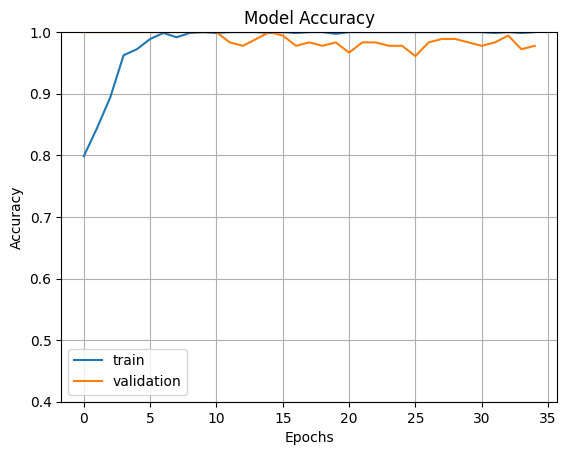

In [ ]:
fig1 = plt.gcf()
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show() 

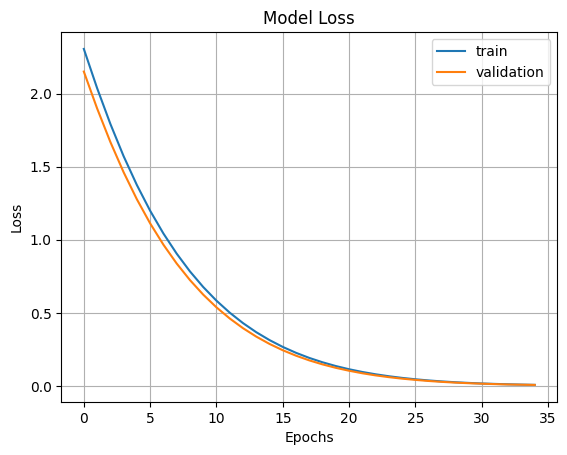

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode="binary",
    seed=123,
    image_size=(img_height, img_width),
    shuffle=False,
    batch_size=batch_size
)

import os

true_labels = []
classes = ["mm", "nm"]

#CONVERT TO 0 OR 1
for class_name in test_ds.class_names:
    class_path = os.path.join(test_dir, class_name)
    if os.path.exists(class_path):
        images = os.listdir(class_path)
        if class_name == "mm":
            true_labels.extend([0] * len(images))
            print(0)
        elif class_name == "nm":
            true_labels.extend([1] * len(images))
            print(1)
        print(class_name)

print("true, ",true_labels)

predictions=resnet_model.predict(test_ds)
predicted_labels = [1 if pred > 0.5 else 0 for pred in predictions]

print

auc_score = roc_auc_score(true_labels, predictions)

correct_predictions = sum([1 for true, pred in zip(true_labels, predicted_labels) if true == pred])
total_predictions = len(true_labels)
accuracy = correct_predictions / total_predictions

print(predictions)
print("AUC: {:.2}".format(auc_score))
print("Accuracy: {:.2%}".format(accuracy))




Found 379 files belonging to 2 classes.
0
mm
1
nm
true,  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [ ]:


# predictions = resnet_model.predict(test_ds)
# predicted_labels = [1 if pred > 0.5 else 0 for pred in predictions]

# true_labels = []
# for images, labels in test_ds:
#     true_labels.extend(labels.numpy())

# # Convert the labels to integers
# true_labels = [int(label) for label in true_labels]

# print("True Labels:", true_labels)
# print("Predicted Labels:", predicted_labels)

In [ ]:
# true_labels = []
# for images, labels in test_ds:
#     true_labels.extend(labels.numpy())

# true_labels = [int(label) for label in true_labels]

# correct_predictions = sum([1 for true, pred in zip(true_labels, predicted_labels) if true == pred])
# total_predictions = len(true_labels)
# accuracy = correct_predictions / total_predictions

# incorrect_predictions = total_predictions - correct_predictions

# print("Accuracy: {:.2%}".format(accuracy))
# print("Correct Predictions: {} out of {}".format(correct_predictions, total_predictions))
# print("Incorrect Predictions: {} out of {}".format(incorrect_predictions, total_predictions))

In [ ]:
# from sklearn.metrics import roc_auc_score

# y_true = []
# y_pred = []

# for images, labels in test_ds:
#     y_true.extend(labels)
#     y_pred.extend(resnet_model.predict(images).flatten())

# auc_score = roc_auc_score(y_true, y_pred)
# print("AUC Score:", auc_score)

# #train_ds = integer )trainset and validation set
# #test_ds not

# print(y_true)
# print(y_pred)

In [ ]:
# output_class=class_names[np.argmax(pred)]
# print("The predicted class is", output_class)